In [1]:
import csv
import numpy as np
import collections

import plotly
import plotly.graph_objs as go
from plotly import tools
import plotly.io as pio
from matplotlib import pyplot as plt

def format_tool_id(tool_link):
        tool_id_split = tool_link.split( "/" )
        tool_id = tool_id_split[ -2 ] if len( tool_id_split ) > 1 else tool_link
        return tool_id

tool_usage_file = "data/tool_usage/tool-popularity.tsv"
#tool_usage_file = "data/tool_usage/tool-popu-date.tsv"
cutoff_date = '2017-12-01'
tool_usage_dict = dict()
tool_list = list()
dates = list()
with open( tool_usage_file, 'rt' ) as usage_file:
    tool_usage = csv.reader(usage_file, delimiter='\t') 
    for index, row in enumerate(tool_usage):
        if (str(row[1]) > cutoff_date) is True:
            tool_id = format_tool_id(row[0])
            tool_list.append(tool_id)
            if row[1] not in dates:
                dates.append(row[1])
            if tool_id not in tool_usage_dict:
                tool_usage_dict[tool_id] = dict()
                tool_usage_dict[tool_id][row[1]] = int(row[2])
            else:
                curr_date = row[1]
                if curr_date in tool_usage_dict[tool_id]:
                    tool_usage_dict[tool_id][curr_date] += int(row[2])
                else:
                    tool_usage_dict[tool_id][curr_date] = int(row[2])
unique_dates = list(set(dates))
for tool in tool_usage_dict:
    usage = tool_usage_dict[tool]
    #median_usage = np.median(list(usage.values()))
    dts = usage.keys()
    dates_not_present = list(set(unique_dates) ^ set(dts))
    for dt in dates_not_present:
        tool_usage_dict[tool][dt] = 0 #median_usage
    tool_usage_dict[tool] = collections.OrderedDict(sorted(usage.items()))
tool_list = list(set(tool_list))
print(tool_list)

['__APPLY_RULES__', 'gatk2_variant_filtration', 'mothur_chimera_check', 'augustus', 'rseqc_geneBody_coverage', 'nanopolish_methylation', 'khmer_abundance_distribution_single', 'fastq_filter', 'plotly_ml_performance_plots', 'metaspades', 'EMBOSS: getorf42', 'mothur_dist_shared', 'tabular_to_fastq', 'cshl_fastx_trimmer', 'melt', 'deeptools_alignmentsieve', 'bcftools_csq', 'MultiplexResolver', 'mass_spectrometry_imaging_segmentations', 'enasearch_search_data', 'ctb_openmg', 'PeptideIndexer', 'mothur_remove_groups', 'gmx_em', 'flye', 'ebi_sra_main', 'mimodd_varreport', 'seqtk_mergefa', 'SeedListGenerator', 'bedtools_genomecoveragebed_histogram', 'gtf2bedgraph', 'gatk2_variant_annotator', 'EMBOSS: einverted28', 'trinity_analyze_diff_expr', 'vcfcommonsamples', 'CONVERTER_interval_to_bed6_0', 'rseqc_bam_stat', 'twobit_builder_data_manager', 'morpheus', 'deseq2', 'EMBOSS: cpgplot15', 'bedtools_nucbed', 'gffcompare_to_bed', 'snpsift_vartype', 'cast', 'join1', 'gd_select_snps', 'atactk_trim_adap

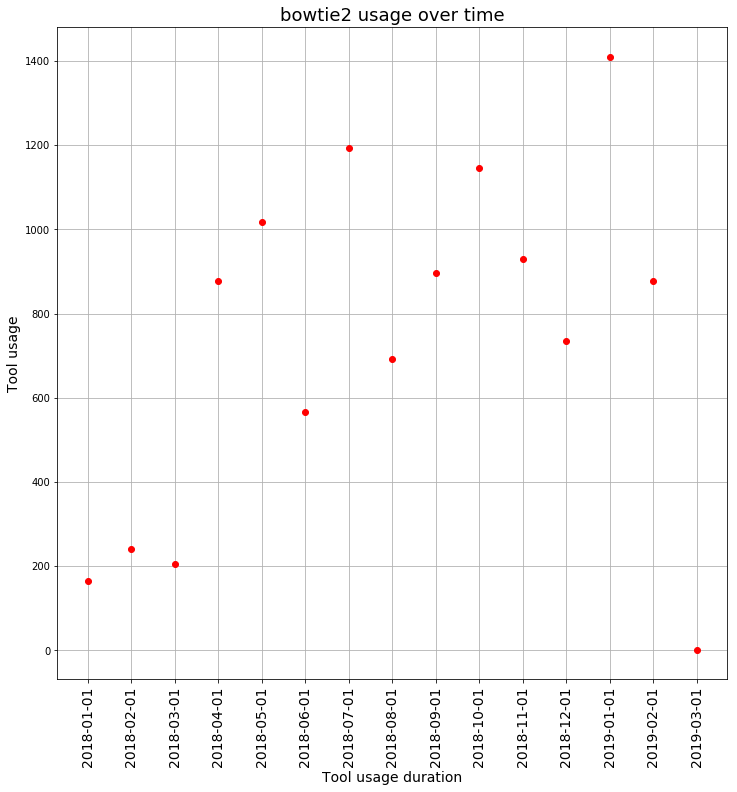

{'regressor__alpha': 1.0}
972.8011594202899


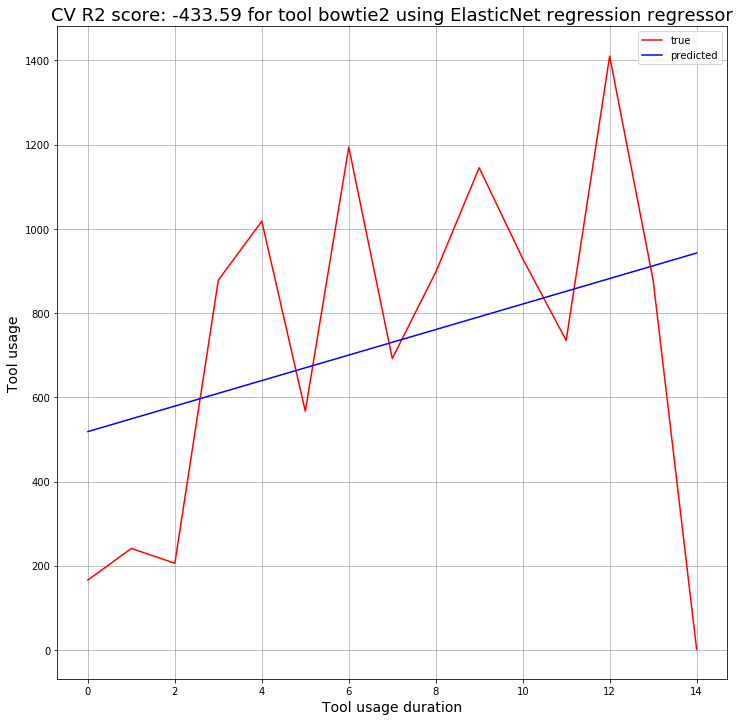

{'regressor__degree': 2, 'regressor__kernel': 'rbf'}
877.3240738952422


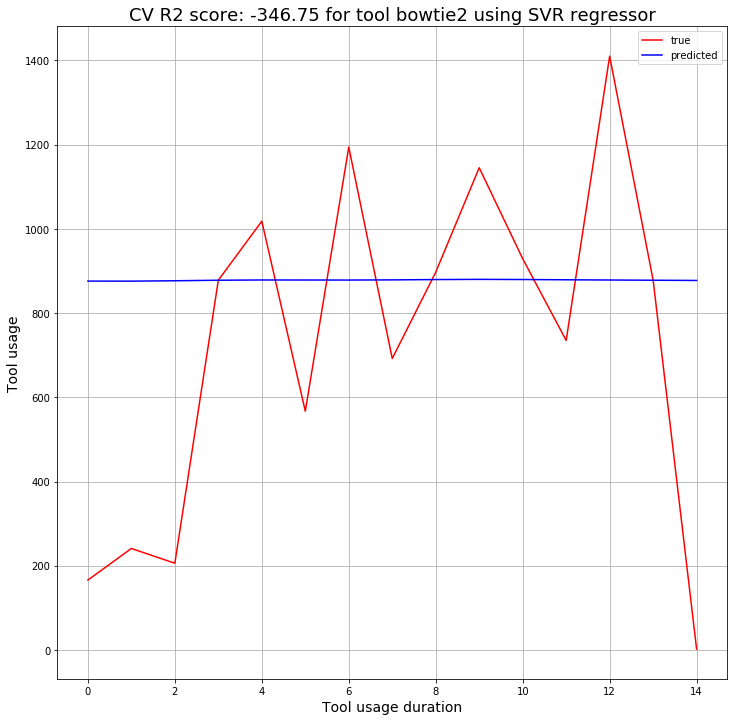

's_time = time.time()\nprint(\'Learning the usage...\')\nr2_en = list()\nr2_svr = list()\ntrunc_tool_list = tool_list[:200]\nfor tool_name in trunc_tool_list:\n    y_val = []\n    x_val = []\n    tool_data = tool_usage_dict[tool_name]\n    for x, y in tool_data.items():\n        x_val.append(x)\n        y_val.append(y)\n    x_pos = np.arange(len(x_val))\n    x_reshaped = x_pos.reshape(len(x_pos), 1)\n    y_reshaped = np.reshape(y_val, (len(x_pos), 1))\n    predictions_en, score_en = predict_curve(x_reshaped, y_reshaped, x_reshaped, \'en\')\n    predictions_svr, score_svr = predict_curve(x_reshaped, y_reshaped, x_reshaped, \'svr\')\n    r2_en.append(score_en)\n    r2_svr.append(score_svr)\n    #print("%s finished" % tool_name)\ne_time = time.time()\nprint("Time taken: %d" % int(e_time - s_time))\nplt.figure(figsize=(12, 12))\nx_pos = np.arange(len(r2_en))\nplt.plot(x_pos, r2_en, \'r\')\nplt.plot(x_pos, r2_svr, \'b\')\nplt.xlabel(\'Tools\', size=size_label)\nplt.ylabel(\'5 fold cross-val

In [8]:
import warnings
from scipy import interpolate
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
import xgboost as xgb 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import time

warnings.filterwarnings("ignore")

size_title = 18
size_label = 14
n_pred = 2


def predict_curve(x_reshaped, y_reshaped, x_new, regressor):
    score = 0.0
    if regressor == 'lr':
        model = LinearRegression().fit(x_reshaped, y_reshaped)
    elif regressor == 'svr':
        pipe = Pipeline(steps=[('regressor', SVR(gamma='scale'))])
        param_grid = {
            'regressor__kernel': ['rbf', 'poly', 'linear'],
            'regressor__degree': [2, 3],
            #'regressor__coef0': [0.0, 0.1, 0.5],
            #'regressor__C': [0.25, 0.5, 1.0, 1.5, 2.0],
        }
    elif regressor == 'en':
        pipe = Pipeline(steps=[('regressor', ElasticNet())])
        param_grid = {
            'regressor__alpha': [0.1, 0.5, 0.75, 1.0],
        }
    
    search = GridSearchCV(pipe, param_grid, iid=False, cv=5, return_train_score=False, scoring='neg_mean_absolute_error', n_jobs=2, error_score=1)
    search.fit(x_reshaped, y_reshaped)
    print(search.best_params_)
    model = search.best_estimator_
    future_pt = [x_reshaped[-1][0] + 1]
    future_pt = np.reshape(future_pt, (1, 1))
    future_pred = model.predict(future_pt)
    print(future_pred[0])
    return model.predict(x_new), search.best_score_

def plot_predictions(true, predictions, tool_name, regressor, score):
    
    plt.figure(figsize=(12, 12))
    x_pos = np.arange(len(predictions))
    plt.plot(x_pos, true, 'r')
    plt.plot(x_pos, predictions, 'b')
    plt.xlabel('Tool usage duration', size=size_label)
    plt.ylabel('Tool usage', size=size_label)
    #plt.xticks(range(len(x_pos)), x_pos, size=size_label, rotation='vertical')
    plt.title(('CV R2 score: %.2f for tool %s using %s regressor' % (score, tool_name, regressor)), size=size_title)
    plt.grid(True)
    plt.legend(['true', 'predicted'])
    plt.show()
    

def plot_hist(tool_name):
    y_val = []
    x_val = []
    tool_data = tool_usage_dict[tool_name]
    for x, y in tool_data.items():
        x_val.append(x)
        y_val.append(y)

    plt.figure(figsize=(12, 12))
    x_pos = np.arange(len(x_val))
    plt.plot(x_pos, y_val, 'ro')
    plt.xlabel('Tool usage duration', size=size_label)
    plt.ylabel('Tool usage', size=size_label)
    plt.xticks(range(len(x_val)), x_val, size=size_label, rotation='vertical')
    plt.title(('%s usage over time' % tool_name), size=size_title)

    plt.grid(True)
    plt.show()
    
    x_pos = np.arange(len(x_val))
    x_reshaped = x_pos.reshape(len(x_pos), 1)
    y_reshaped = np.reshape(y_val, (len(x_pos), 1))

    predictions_en, score_en = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'en')
    plot_predictions(y_reshaped, predictions_en, tool_name, 'ElasticNet regression', score_en)
    
    predictions_svr, score_svr = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'svr')
    plot_predictions(y_reshaped, predictions_svr, tool_name, 'SVR', score_svr)
    
plot_hist('bowtie2')
    
# get performance of linear regressor and svr
'''s_time = time.time()
print('Learning the usage...')
r2_en = list()
r2_svr = list()
trunc_tool_list = tool_list[:200]
for tool_name in trunc_tool_list:
    y_val = []
    x_val = []
    tool_data = tool_usage_dict[tool_name]
    for x, y in tool_data.items():
        x_val.append(x)
        y_val.append(y)
    x_pos = np.arange(len(x_val))
    x_reshaped = x_pos.reshape(len(x_pos), 1)
    y_reshaped = np.reshape(y_val, (len(x_pos), 1))
    predictions_en, score_en = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'en')
    predictions_svr, score_svr = predict_curve(x_reshaped, y_reshaped, x_reshaped, 'svr')
    r2_en.append(score_en)
    r2_svr.append(score_svr)
    #print("%s finished" % tool_name)
e_time = time.time()
print("Time taken: %d" % int(e_time - s_time))
plt.figure(figsize=(12, 12))
x_pos = np.arange(len(r2_en))
plt.plot(x_pos, r2_en, 'r')
plt.plot(x_pos, r2_svr, 'b')
plt.xlabel('Tools', size=size_label)
plt.ylabel('5 fold cross-validated R2 scores', size=size_label)
plt.title(('Comparison of performances of ElasticNet and SVR'), size=size_title)
plt.legend(['ElasticNet', 'SVR'])
plt.grid(True)
plt.show()'''

